# 📡 Ultrasonic — Status Classification

This notebook loads ultrasonic sensor data (`sensor_data.csv`), performs EDA, generates synthetic samples for robust training, trains a **Decision Tree Classifier** for status prediction, and exports the model.

> **Note:** The raw dataset only has 4 rows, so we generate synthetic data based on the observed patterns to enable meaningful model training.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib, os, warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
print('Libraries loaded ✅')

Libraries loaded ✅


## 1 — Load Raw Data

In [2]:
# Load only valid numeric rows (skip any trailing text lines)
raw = pd.read_csv('../raw/sensor_data.csv')
raw = raw[pd.to_numeric(raw['distance'], errors='coerce').notnull()].copy()
raw['distance'] = raw['distance'].astype(float)
raw['speed'] = raw['speed'].astype(float)
raw['status'] = raw['status'].astype(int)

print(f'Raw rows: {len(raw)}')
raw

Raw rows: 3


,distance,speed,status
0,15.2,25.5,2
1,35.8,8.2,1
2,60.0,0.0,0


## 2 — Understand Status Codes

From the raw data we can infer:
- **Status 0** — "Clear" (far distance, no speed → nothing detected)
- **Status 1** — "Warning" (moderate distance, some speed → object approaching)
- **Status 2** — "Danger" (close distance, high speed → imminent collision risk)

In [3]:
status_map = {0: 'Clear', 1: 'Warning', 2: 'Danger'}
raw['status_label'] = raw['status'].map(status_map)
raw

,distance,speed,status,status_label
0,15.2,25.5,2,Danger
1,35.8,8.2,1,Warning
2,60.0,0.0,0,Clear


## 3 — Generate Synthetic Training Data

Since we only have 3 unique data points, we generate realistic synthetic data following the observed relationships:
- **Clear**: distance 40–100 cm, speed 0–3 cm/s
- **Warning**: distance 20–45 cm, speed 3–15 cm/s
- **Danger**: distance 2–25 cm, speed 10–40 cm/s

In [4]:
np.random.seed(42)
n_per_class = 500

# Clear (status=0): far, no speed
clear = pd.DataFrame({
    'distance': np.random.uniform(40, 100, n_per_class) + np.random.normal(0, 3, n_per_class),
    'speed': np.abs(np.random.normal(1, 1.5, n_per_class)),
    'status': 0
})

# Warning (status=1): moderate distance, some speed
warning = pd.DataFrame({
    'distance': np.random.uniform(20, 45, n_per_class) + np.random.normal(0, 3, n_per_class),
    'speed': np.random.uniform(3, 15, n_per_class) + np.random.normal(0, 1, n_per_class),
    'status': 1
})

# Danger (status=2): close, fast
danger = pd.DataFrame({
    'distance': np.random.uniform(2, 25, n_per_class) + np.random.normal(0, 2, n_per_class),
    'speed': np.random.uniform(10, 40, n_per_class) + np.random.normal(0, 2, n_per_class),
    'status': 2
})

df = pd.concat([clear, warning, danger], ignore_index=True)
df['distance'] = df['distance'].clip(lower=0)
df['speed'] = df['speed'].clip(lower=0)
df['status_label'] = df['status'].map(status_map)

print(f'Synthetic dataset: {len(df)} samples')
print(df['status_label'].value_counts())
df.describe()

Synthetic dataset: 1500 samples
status_label
Clear      500
Warning    500
Danger     500
Name: count, dtype: int64


,distance,speed,status
count,1500.000000,1500.000000,1500.000000
mean,38.494097,11.792339,1.000000
std,26.570889,11.257086,0.816769
min,0.000000,0.002136,0.000000
25%,17.564897,2.109597,0.000000
50%,32.801519,8.997239,1.000000
75%,54.366552,17.607335,2.000000
max,104.712767,44.172503,2.000000


## 4 — Exploratory Data Analysis

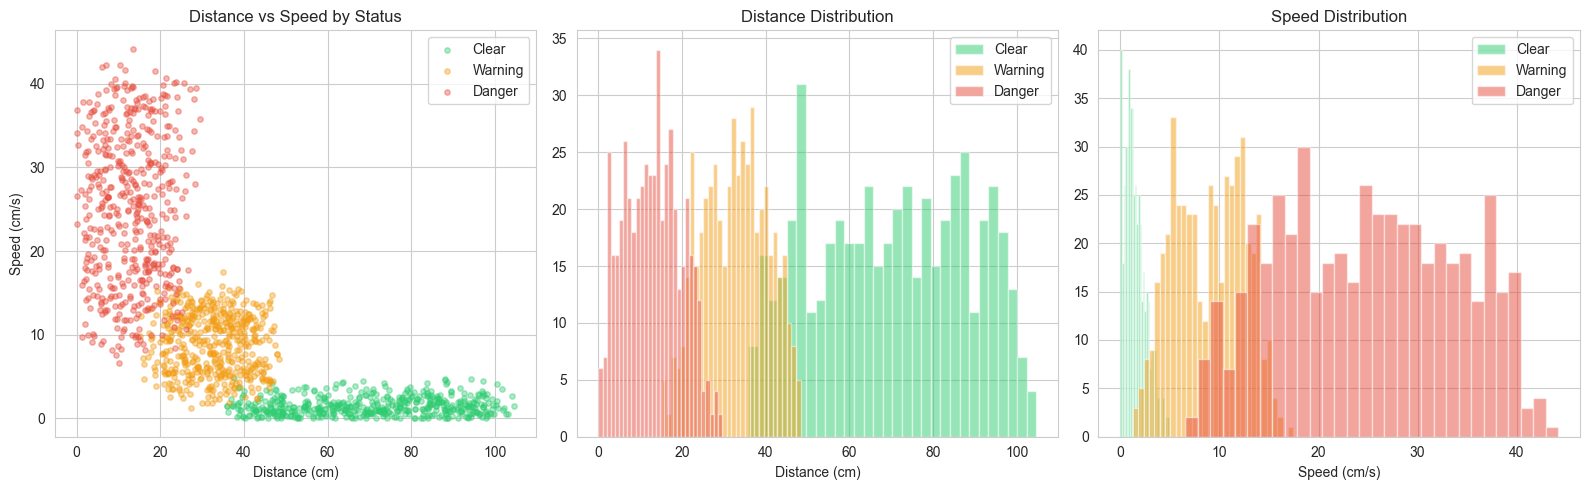

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

colors = {'Clear': '#2ecc71', 'Warning': '#f39c12', 'Danger': '#e74c3c'}

# Scatter plot
for label, color in colors.items():
    subset = df[df['status_label'] == label]
    axes[0].scatter(subset['distance'], subset['speed'], c=color, alpha=0.4, s=15, label=label)
axes[0].set_title('Distance vs Speed by Status')
axes[0].set_xlabel('Distance (cm)')
axes[0].set_ylabel('Speed (cm/s)')
axes[0].legend()

# Distance distribution
for label, color in colors.items():
    axes[1].hist(df[df['status_label'] == label]['distance'], bins=30, alpha=0.5, label=label, color=color)
axes[1].set_title('Distance Distribution')
axes[1].set_xlabel('Distance (cm)')
axes[1].legend()

# Speed distribution
for label, color in colors.items():
    axes[2].hist(df[df['status_label'] == label]['speed'], bins=30, alpha=0.5, label=label, color=color)
axes[2].set_title('Speed Distribution')
axes[2].set_xlabel('Speed (cm/s)')
axes[2].legend()

plt.tight_layout()
plt.show()

## 5 — Train Decision Tree Classifier

In [6]:
feature_cols = ['distance', 'speed']
X = df[feature_cols]
y = df['status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

dt_model = DecisionTreeClassifier(max_depth=6, random_state=42)
dt_model.fit(X_train, y_train)
y_pred = dt_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)')
print('\nClassification Report:')
print(classification_report(y_test, y_pred, target_names=['Clear', 'Warning', 'Danger']))

Accuracy: 0.9700 (97.00%)

Classification Report:
              precision    recall  f1-score   support

       Clear       1.00      0.99      0.99       100
     Warning       0.95      0.96      0.96       100
      Danger       0.96      0.96      0.96       100

    accuracy                           0.97       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300



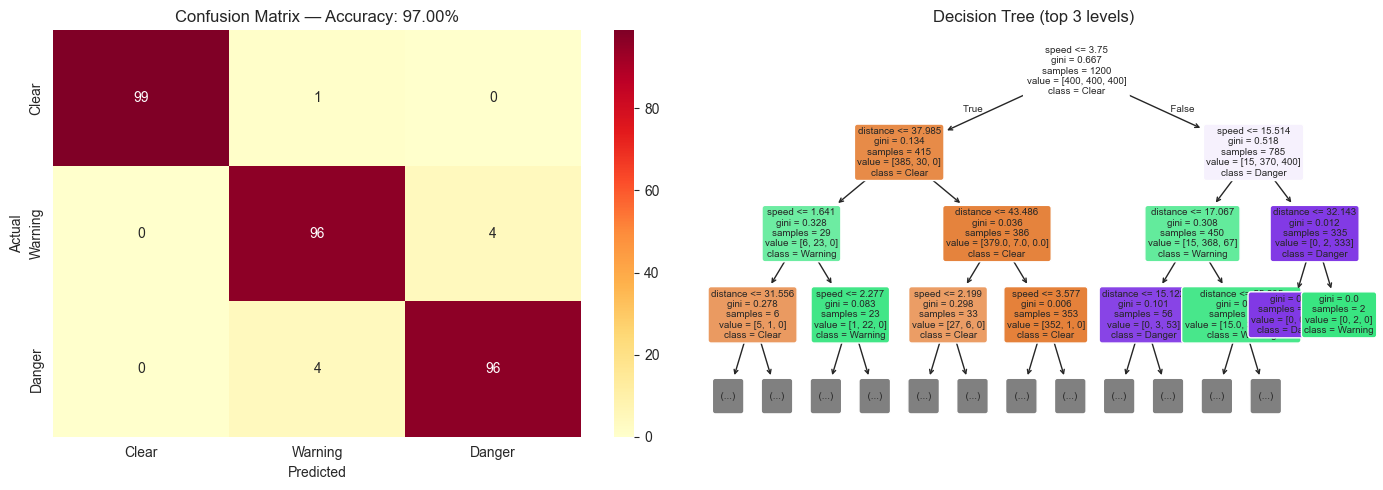

In [7]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd',
            xticklabels=['Clear', 'Warning', 'Danger'],
            yticklabels=['Clear', 'Warning', 'Danger'], ax=axes[0])
axes[0].set_title(f'Confusion Matrix — Accuracy: {accuracy*100:.2f}%')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Decision Tree visualization
plot_tree(dt_model, feature_names=feature_cols, class_names=['Clear', 'Warning', 'Danger'],
          filled=True, rounded=True, ax=axes[1], fontsize=7, max_depth=3)
axes[1].set_title('Decision Tree (top 3 levels)')

plt.tight_layout()
plt.show()

## 6 — Decision Boundary Visualization

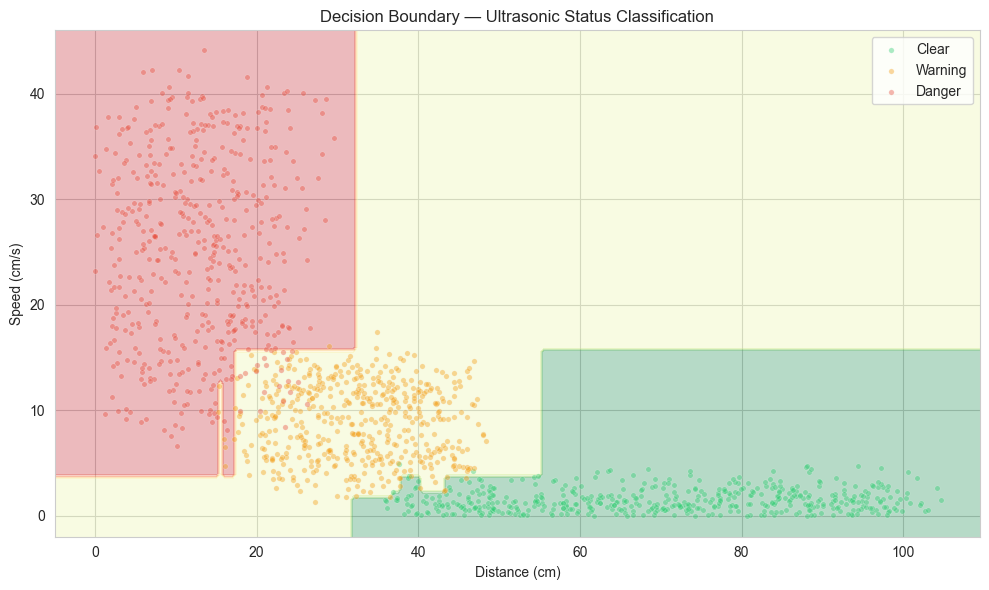

In [8]:
# Create mesh grid for decision boundary
h = 0.5
x_min, x_max = df['distance'].min() - 5, df['distance'].max() + 5
y_min, y_max = df['speed'].min() - 2, df['speed'].max() + 2
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = dt_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdYlGn_r)

for label, (status_val, color) in zip(['Clear', 'Warning', 'Danger'],
                                       [(0, '#2ecc71'), (1, '#f39c12'), (2, '#e74c3c')]):
    subset = df[df['status'] == status_val]
    plt.scatter(subset['distance'], subset['speed'], c=color, alpha=0.4, s=15, label=label, edgecolors='white', linewidth=0.3)

plt.title('Decision Boundary — Ultrasonic Status Classification')
plt.xlabel('Distance (cm)')
plt.ylabel('Speed (cm/s)')
plt.legend()
plt.tight_layout()
plt.show()

## 7 — Export Model

In [9]:
os.makedirs('../models', exist_ok=True)

joblib.dump({
    'decision_tree': dt_model,
    'features': feature_cols,
    'status_map': status_map,
    'accuracy': accuracy
}, '../models/ultrasonic_model.pkl')

print('✅ Model exported to models/ultrasonic_model.pkl')

✅ Model exported to models/ultrasonic_model.pkl
